# Mini-Project - Covid-19 Cough Audio Classification

1. Explore the dataset through code
    * How many samples does the dataset contain?
    * How many classes? How many samples per class? Show a histogram of the number of instances per class
    * Play a random sample from each class
    * Describe if/how you think the data distribution will affect training of a classifier.
    * Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice

In [67]:
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import os

# Load in metadata.csv
data_path = r"metadata_compiled.csv"
data = pd.read_csv(data_path, sep=",")
#data.columns = data.columns.str.replace(" ", "")

data = data[["uuid","cough_detected","SNR","age","gender","status"]].loc[data['cough_detected'] >= 0.5].dropna()
print(data["status"].value_counts())
print("Total samples",len(data))

#data.to_csv("status_check.csv")

#plt.figure(figsize=(6,4))
#plt.title("Histogram of Patient Status")
#plt.bar(data['status'].value_counts().index, data['status'].value_counts())
#plt.xticks(rotation=20, ha='right', fontsize=8)
#plt.xlabel('Class', fontsize=8)
#plt.ylabel('Frequency', fontsize=8)
#plt.show()

#print(data["cough_detected"][0])

status
healthy        9291
symptomatic    2035
COVID-19        676
Name: count, dtype: int64
Total samples 12002


In [ ]:
#print(data["uuid"][1])

data_dir_path = r"../Dataset/"
# glob(os.path.join(clip_dir, '*.txt')):
t = os.listdir(data_dir_path)

"""
#data = []
#for i in t:
#    if i.endswith(".webm") or i.endswith(".ogg"):
#        data.append(os.path.join(data_dir_path, i))

#data = pd.DataFrame(data, columns=["Links"]).to_csv("files.csv", index=False)  

#print(t := os.path.join(data_dir_path, data["uuid"][1]+".json"))

#print(t[0])
#print(data["uuid"][1])
"""

webm_data = []
ogg_data = []
c = 0
for file in data['uuid']:
    if os.path.exists(os.path.join(data_dir_path, f'{file}.webm')):
        webm_data.append(os.path.join(data_dir_path, f'{file}.webm'))
    elif os.path.exists(os.path.join(data_dir_path, f'{file}.ogg')):
        ogg_data.append(os.path.join(data_dir_path, f'{file}.ogg'))
    #file_path = os.path.join(data_dir_path, f"{path}.webm")
    #webm_data.append(file_path)
    #json_data = pd.read_json(file_path, orient="table")
    #print(json_data)
  
webm_data = pd.DataFrame(webm_data)
webm_data.to_csv("webm_data.csv")
ogg_data = pd.DataFrame(ogg_data)
ogg_data.to_csv("ogg_data.csv")

In [55]:
from torch.utils.data import Dataset
import torchaudio
import torch

class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, data, label_encoder = None):
        # Initialize attributes
        self.data_dir = data_dir
        self.data = data["uuid"]
        self.label = data["status"]
        self.label_encoder = label_encoder
        self.sample_rate = {}
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        # Extract audio sample from idx
        audio_path = self.data[idx]
              
        # Load in audio
        audio_sample, sample_rate = torchaudio.load(audio_path, format="FFmpeg")
        self.sample_rate[idx] = sample_rate
        
        # Extract audio label from idx and transform
        audio_label = [self.label[idx]]
        audio_label = self.label_encoder.transform(audio_label)
        
        return audio_sample, audio_label
    
    def __get_sample_rate__(self, idx):
        return self.sample_rate.get(idx)

In [57]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
import librosa

# Stolen from pytorch tutorial xd
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [75]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    # A data tuple has the form:
    # waveform, label
    
    # Separate audio samples and labels
    waveforms, labels = zip(*batch)

    # Pad the audio samples
    padded_waveforms = pad_sequence(waveforms)

    # Convert labels to tensor
    labels = torch.tensor(labels)

    return padded_waveforms, labels

In [87]:
def undersample(data, n , normalize=False):
    # Step 1: Identify majority class
    class_counts = data['status'].value_counts()
    majority_class = class_counts.idxmax()

    # Step 2: Calculate desired class distribution (e.g., balanced distribution)
    desired_class_count = n  # Target number of samples for each class

    # Step 3: Select subset from majority class
    undersampled_data_majority = data[data['status'] == majority_class].sample(n=desired_class_count)

    # Combine with samples from minority classes
    undersampled_data_minority = data[~(data['status'] == majority_class)]

    # Combine undersampled majority class with minority classes
    undersampled_data = pd.concat([undersampled_data_majority, undersampled_data_minority])

    # Shuffle the undersampled dataset
    undersampled_data = undersampled_data.sample(frac=1).reset_index(drop=True)
    
    return undersampled_data

In [101]:
def weighted_sample(data):
    # Find class distribution
    class_counts = data["status"].value_counts()
    #print(class_counts)
    
    # Check class weights
    class_weights = 1/class_counts
    #print(class_weights)
    
    # Adjust weighting to each sample
    sample_weights = [1/class_counts[i] for i in data["status"].values]
    #print("len sample weights:",len(sample_weights))
    
    return sample_weights
    

In [88]:
from sklearn.model_selection import train_test_split
def preprocess_dataset(data, test_size):
    # Extract audio samples and labels
    X = data.drop(columns=["status"])
    y = data["status"]

    # Perform a stratified split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Combine audio samples and target labels for training and validation sets
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    
    return train_data, test_data
    

In [91]:
def visualize_dataset(data, normalize, title):
    print(f"{title} Distribution")
    print(data["status"].value_counts(normalize=normalize))
    print("Total samples",len(data))
    
    plt.figure(figsize=(6,4))
    plt.title(f"Histogram of Patient Status\n- {title}")
    plt.bar(data['status'].value_counts().index, data['status'].value_counts())
    plt.xticks(rotation=20, ha='right', fontsize=8)
    plt.xlabel('Class', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.show()

In [110]:
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import os

def preprocess_data(data_path, data_dir_path):
    # Read data file then remove every column other than the specified columns
    # Removes empty samples and filters through cough probability
    data = pd.read_csv(data_path, sep=",")
    data = data[["uuid","cough_detected","SNR","age","gender","status"]].loc[data['cough_detected'] >= 0.5].dropna()
    
    # Check if the following MP3 with uuid exists
    mp3_data = []
    non_exist = []
    for file in data['uuid']:
        if os.path.exists(os.path.join(data_dir_path, f'{file}.mp3')):
            mp3_data.append(os.path.join(data_dir_path, f'{file}.mp3'))
        else:
            #print("Does not exist!")
            non_exist.append(file)
        #elif os.path.exists(os.path.join(data_dir_path, f'{file}.ogg')):
        #    ogg_data.append(os.path.join(data_dir_path, f'{file}.ogg'))
        
    # Remove entries with missing MP3 files from the original data
    data = data[~data['uuid'].isin(non_exist)]
    
    # Replace the uuids with the path to uuid
    data["uuid"] = mp3_data
    
    data.to_csv("audio_data.csv")
    print("Finished!")
    return 1

# Define data variables
data_meta = "metadata_compiled.csv"
data = pd.read_csv("audio_data.csv")
data_dir_path = r"../Dataset/MP3/"

# Preprocess data if you havent already
#data = preprocess_data(data, data_dir_path)

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform labels into encoded form
labels = ["healthy", "symptomatic", "COVID-19"]
encoded_labels = le.fit_transform(labels)

# Visualize standard dataset
#visualize_dataset(data, True, "Standard")

# Prepare standard dataset
train_data, test_data = preprocess_dataset(data, 0.33)
print(train_data)
print(train_data.shape)

# Create undersampled version
undersampled_data = undersample(data, 2000, True)

# Visualize undersampled dataset
#visualize_dataset(undersampled_data, True, "Undersampled")

# Prepare undersampled dataset
train_undersampled_data, test_undersampled_data = preprocess_dataset(undersampled_data, 0.33)

# Preparing weighted dataset
sample_weights = weighted_sample(data)
weighted_Sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(data), replacement=True)


# Create AudioDataset instances for training and validation sets
"""
We should try training with different datasets such as:
 * Standard
 * Undersampled
 * Weighted

"""
train_dataset = AudioDataset(data_dir_path, train_data, le)
validation_dataset = AudioDataset(data_dir_path, test_data, le)

# Create training and test dataloader instances
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

train_undersampled_dataloader = DataLoader(train_undersampled_data, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
test_undersampled_dataloader = DataLoader(test_undersampled_data, batch_size=64, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

train_weighted_dataloader = DataLoader(train_data, sampler=weighted_Sampler, batch_size=64, num_workers=4, collate_fn=collate_fn, pin_memory=True)
test_weighted_dataloader = DataLoader(test_data, sampler=weighted_Sampler, batch_size=64, num_workers=4, collate_fn=collate_fn, pin_memory=True)

      Unnamed: 0                                               uuid  \
5359       13097  ../Dataset/MP3/7959fa37-0e29-48c9-86f1-645a5bd...   
9339       22828  ../Dataset/MP3/d49bc3be-7272-4ce6-974c-fc2da8f...   
6140       15032  ../Dataset/MP3/8b4247ee-a7ff-49eb-8dc3-0c9b82e...   
5721       13954  ../Dataset/MP3/814b168b-0843-4a79-a149-2a9b54d...   
9884       24129  ../Dataset/MP3/e0988e94-2b3e-4589-b60e-aa23063...   
...          ...                                                ...   
2102        5156  ../Dataset/MP3/3084ac2c-1cfd-4582-afd7-d61caea...   
4188       10200  ../Dataset/MP3/5f03fd3e-863b-4b17-bb99-4137766...   
8589       21031  ../Dataset/MP3/c39989df-2535-414d-9997-862d7eb...   
230          557  ../Dataset/MP3/057f02e2-865c-4f4b-b08d-1538d11...   
1872        4612  ../Dataset/MP3/2b7e12c6-6863-46a4-9135-bd3686a...   

      cough_detected        SNR   age  gender       status  
5359          0.8803  43.766093  21.0  female      healthy  
9339          0.6608   5.

path ../Dataset/MP3/00039425-7f3a-42aa-ac13-834aaa2b6b92.mp3
(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), array([1]))
path ../Dataset/MP3/0009eb28-d8be-4dc1-92bb-907e53bc5c7a.mp3
(tensor([[-6.9132e-17, -7.1062e-17, -7.3007e-17,  ..., -1.0154e-03,
         -1.1018e-03, -9.3406e-04]]), array([1]))
len t 469440
len t3 216000
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
[1]
48000
decoded label ['healthy']


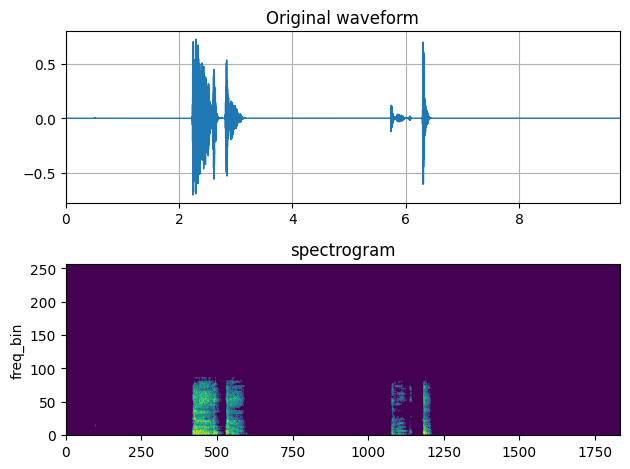

In [66]:
import torchaudio.transforms as T

print(t := test.__getitem__(0))
print(t3 := test.__getitem__(1))
print("len t", len(t[0][0]))
print("len t3", len(t3[0][0]))

print(t[0])
print(t[1])

print(t2 := test.__get_sample_rate__(0))

print("decoded label",le.inverse_transform(t[1]))

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(t[0])
fig, axs = plt.subplots(2, 1)
plot_waveform(t[0], t2, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model = M5(n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

cuda
M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=3, bias=True)
)
N